# Uncovering Cuisines Based on Ingredients
by Chelsea Anne S. Ong

## Loading of the Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4g}'.format
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## classifier ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import pickle
import re
import json
%matplotlib inline


## Loading the DataSet

In [2]:
with open('train.json') as train:
    training=json.load(train)

## Data Pre-Processing

The Data pre-processing involves: 
1. Turning the json file into a Pandas DataFrame. This step matches each recipe into its set of ingredients and put it into dataframe named `dirty_df`.
2. Creating a function for the modified one-hot encoding and implement it. The end result is a one-hot encoded dataframe with recipe as entries and ingredients as features.
3. Note that the data is highly dimensional and sparse, it will take time to run the program. Undersampling is done to shorten run time.

#### Turn JSON file into a Pandas DataFrame

In [3]:
count_ings={} ## dictionary connecting id with ingredients
a_cuisine={} ## dictionary connecting id with cuisine
series=pd.Series()
for dish in training:  
    count_ings[dish['id']] = dish['ingredients']
    a_cuisine[dish['id']] = dish['cuisine']
    
dirty_df = pd.DataFrame.from_dict(count_ings,orient = 'index')
dirty_df['cuisine']=pd.Series(a_cuisine)

`dirty_df` displays the id as entries and ingredients as columns. The last column contains the cuisine the id belongs to.

In [4]:
dirty_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,cuisine
10259,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,None,...,None,None,None,None,None,None,None,None,None,greek
25693,plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,...,None,None,None,None,None,None,None,None,None,southern_us
20130,eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,...,None,None,None,None,None,None,None,None,None,filipino
22213,water,vegetable oil,wheat,salt,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,indian
13162,black pepper,shallots,cornflour,cayenne pepper,onions,garlic paste,milk,butter,salt,lemon juice,...,None,None,None,None,None,None,None,None,None,indian


Past studies suggests the use of the TF-IDF Vectorizer due to the nature of the data which is text data. There have been no studies doing one-hot encoding where each ingredient will be treated as features. I wanted to do a different approach this time and the function is shown below.
#### The one-hot encode function

This modified one-hot encode function prevents ingredients from repeating. In the `pd.get_dummies` function, it takes the order of the ingredients into account and repeating ingredients can possibly happen.

In [5]:
def onehot_encode(x):
    features = set(x)
    if 'temp' in features:
        features.remove('temp')
#     print(features)
    food = pd.Series(index=ingredients)
    food[features] = 1
    return food

#### List of cuisines and list of ingredients

In [6]:
ingredients = set(dirty_df.values.reshape(1,-1).tolist()[0]) 
## list of unique ingredients
cuisines=list(dirty_df['cuisine'].unique()) ## list of cuisines

In [7]:
dirty_df1=dirty_df.drop(columns='cuisine')
dirty_df1.fillna(value='temp',inplace=True)

This step involves turning the whole dataframe into one-hot encode format.

In [8]:
df_onehot=dirty_df1.apply(onehot_encode,axis=1).fillna(0)

In [9]:
df_onehot.head()

,back bacon rashers,asti spumante,whole wheat pita pockets,diced lamb,green tea,cones,fenugreek,riblets,swiss,tuna fillets,...,snappers,cubed pancetta,brats,snip fresh dill,puff pastry cups,frozen basil,Cox's Orange Pippin,sunflower kernels,garbanzo bean flour,chinese duck sauce
10259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# df_onehot.to_pickle('onehot.pkl')

#### Assign `df_onehot` to `onehot` to preserve the original dataframe.

In [10]:
onehot=df_onehot

Drop ingredients that appeared less than 25 times to reduce complexity of data and assign in to `bal_25` dataframe.

In [11]:
bal_25=onehot.drop(onehot.loc[:,onehot.sum()<25],axis=1)

In [12]:
bal_25.head()

,fenugreek,corn kernels,smoked gouda,unsalted cashews,hellmann' or best food real mayonnais,pepper flakes,red kidney beans,gram flour,olives,ground turkey breast,...,whipped cream,chicken livers,Chinese egg noodles,old bay seasoning,lime wedges,ground chicken,thyme leaves,tumeric,black peppercorns,chipotle
10259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20130,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis
In this step, some analysis is done to have an overview of the dataset.

**<u>Number of recipe count per cuisine** </u><br>
The count for each cuisine can be seen below. The dataset is dominated by italian cuisine followed by mexican with brazilian appearing the least. It can be concluded from this analysis that the dataset is imbalanced.

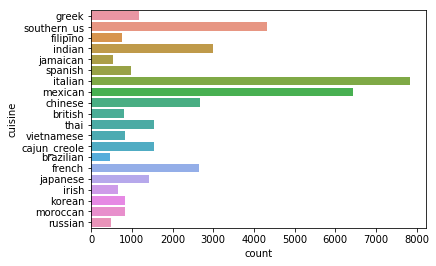

In [13]:
sns.countplot(y=dirty_df['cuisine']);

**<u>Number of Ingredient Distribution per cuisine** </u><br>
It is also important to know how many ingredients are there per cuisine. It can be inferred that each cuisine averages 9-14 ingredients per recipe. The ingredient distribution for each cuisine can be seen below.

In [14]:
mean_count=[]
for c in cuisines:
    mean_count.append(dirty_df[dirty_df['cuisine']==c].count(axis=1).mean())

In [15]:
ings=pd.DataFrame(mean_count,cuisines)

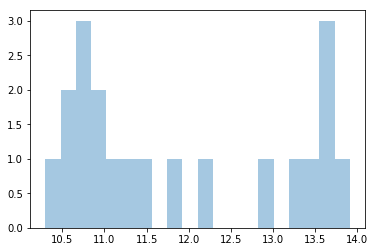

In [16]:
sns.distplot(ings,bins=20,kde=False);

## Machine Learning Model Implementation

In the context of identifying cuisines based on their ingredients, it is necessary to treat this as a classification problem with cuisines as the classes. What is different in this problem is that there are 20 classes which would fall under multi-class classfication. This is not a straightforward classification like binary classification where the target is just 0 or 1. 

There are many machine learning classification models namely:
1. kNN
2. Logistic Regression (L1 and L2 Regularization)
3. Linear Support Vector Machines (L1 and L2 Regularization)
4. Non Linear Support Vector Machines
4. Decision Tree
5. Random Forest
6. Gradient Boosting Method
7. Naive Bayes Classifer 

Judas module is imported where it contains all the code machine learning models.

In [17]:
from judas.regression.automate import Judas as JudasRegressor
from judas.classification.automate import Judas as JudasClassifier
from judas.automate import General

gen=General()

#### PCC

The chance for this dataset to be highly successful is **12.5%.**

Counter({'italian': 7838, 'mexican': 6438, 'southern_us': 4320, 'indian': 3003, 'chinese': 2673, 'french': 2646, 'cajun_creole': 1546, 'thai': 1539, 'japanese': 1423, 'greek': 1175, 'spanish': 989, 'korean': 830, 'vietnamese': 825, 'moroccan': 821, 'british': 804, 'filipino': 755, 'irish': 667, 'jamaican': 526, 'russian': 489, 'brazilian': 467})
State Count:                  0
greek         1175
southern_us   4320
filipino       755
indian        3003
jamaican       526
spanish        989
italian       7838
mexican       6438
chinese       2673
british        804
thai          1539
vietnamese     825
cajun_creole  1546
brazilian      467
french        2646
japanese      1423
irish          667
korean         830
moroccan       821
russian        489

1.25 * Proportion Chance Criterion: 12.50732696708293%


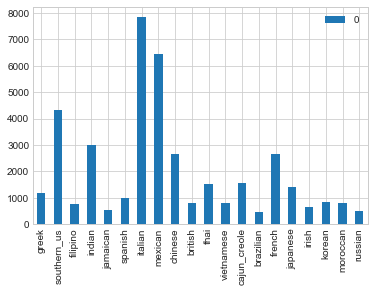

In [18]:
## PCC
gen.pcc(dirty_df['cuisine'])

It is necessary to assign the cuisines into a numerical value for model interpretation.

In [19]:
target=dirty_df['cuisine']
lb = LabelEncoder()
y = lb.fit_transform(target) #the target here is in numerical form
X=bal_25 #assign one-hot encoded dataframe as x

### Model Implementation Proper
We run the models for 5 trials for better consistency. In this project, only the not commented out models will be run due to time constraint. kNN, Non Linear SVM, Gradient Boosting Method are skipped due to very long computation time.  `RandomUnderSampler` is implemented to account for the imbalanced dataset.

<u>Expectations</u><br>
By theory, we expect the linear models to do well than the probabilistic ones (Naive Bayes).

<u>Reality</u> <br>
Naive Bayes performed better than linear models by about 1%.

#### Judas Module Implementation

logistic, reg=l1



logistic, reg=l2



svm, reg=l1



svm, reg=l2



ensemble-decisiontree, max depth=range(1, 20)



ensemble-randomforest, n estimators=range(1, 20)



naive-bayes


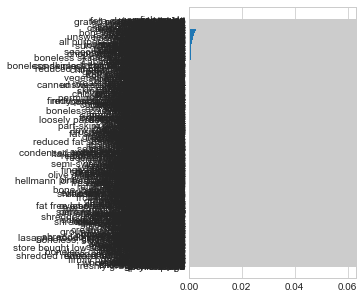

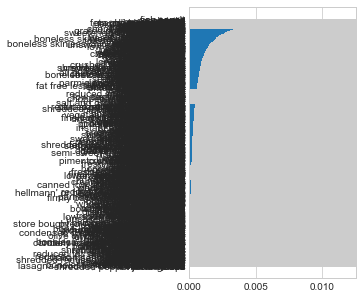

In [87]:
from judas.classification.automate import Judas as JudasClassifier

trials = 5
judasc = JudasClassifier()
params = [
#     {'model': 'knn', 'trials': trials, 'k': range(1, 30)},
    {'model': 'logistic', 'reg': 'l1', 'trials': trials},
    {'model': 'logistic', 'reg': 'l2', 'trials': trials},
    {'model': 'svm', 'reg': 'l1', 'trials': trials},
    {'model': 'svm', 'reg': 'l2', 'trials': trials},
#     {'model': 'nsvm-rbf', 'trials': trials},
    {'model': 'ensemble-decisiontree', 'trials': trials, 'maxdepth': range(1, 20)},
    {'model': 'ensemble-randomforest', 'trials': trials, 'n_est': range(1, 20)},
#     {'model': 'ensemble-gbm', 'trials': trials, 'maxdepth': range(1, 10)},
#     {'model': 'naive-bayes', 'trials': trials, 'tp': 'B'},
#    {'model': 'naive-bayes', 'trials': trials, 'tp': 'G'},
    {'model': 'naive-bayes', 'trials': trials, 'tp': 'M'},
]

judasc.automate(X,y,params)

In [27]:
judasc.score()

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,Logistic (l1),76.79%,C = 1,cachaca
1,Logistic (l2),76.79%,C = 0.75,cachaca
2,Linear SVM (l1),76.94%,C = 0.2,cachaca
3,Linear SVM (l2),77.01%,C = 0.1,cachaca
4,Decision Trees,27.02%,depth = 5,fish sauce
5,Random Forest,53.50%,n-estimator = 19,soy sauce
6,Naive-Bayes (B),77.50%,alpha = 1e-08,NA
7,Naive-Bayes (G),32.33%,alpha = 1e-08,NA
8,Naive-Bayes (M),78.06%,alpha = 1e-08,NA


The model that has the highest accuracy is the Naive-Bayes `MultinomialNB()` with **78.06%**. With linear models, `LinearSVC`(L2) has the highest accuracy with **77.01%** with C=0.1.

The accuracy above only means that cuisine classification is accurate 77.01% of the time using Naive-Bayes Classifier which is not bad for a 20-class classification.

### Top Ingredient Predictor for each cuisine

To determine the top predictor for each cuisine, LinearSVC (L2) is chosen using the best parameters which is at **C=0.1**.

In [45]:
svm = LinearSVC(C=0.1, penalty='l2',max_iter=10000,random_state=1).fit(bal_25,y)

In [49]:
top=pd.DataFrame(svm.coef_,columns=bal_25.columns,index=sorted(cuisines))

In [50]:
top_pred=pd.DataFrame(top.apply(lambda x: x.sort_values(ascending=False).head().index.values,axis=1))

In [51]:
top_pred[0].apply(pd.Series)

,0,1,2,3,4
brazilian,cachaca,dried black beans,tapioca flour,sweetened condensed milk,tapioca starch
british,malt vinegar,golden syrup,double cream,beef tenderloin,dried currants
cajun_creole,cajun seasoning,creole seasoning,creole mustard,andouille sausage,red beans
chinese,mandarin oranges,szechwan peppercorns,chinese five-spice powder,egg roll wrappers,glutinous rice flour
filipino,green papaya,condensed milk,plantains,glutinous rice flour,cooking oil
french,gruyere cheese,grated Gruyère cheese,Niçoise olives,swiss cheese,haricots verts
greek,greek seasoning,feta cheese crumbles,feta cheese,phyllo dough,greek yogurt
indian,masala,curry powder,curds,Madras curry powder,plain yogurt
irish,Irish whiskey,Guinness Beer,corned beef,stout,beef brisket
italian,italian sausage,polenta,gnocchi,pesto,marsala wine


The top 5 predictors for each cuisine are shown above. It can be inferred that:
1. In order to create a dish on a particular cuisine, the ingredients above are a must-have.
2. For example in Korean Cuisine, kimchi and gochuchang base are automatically associated with Korean cuisine. 
3. For chefs and restaurateurs, the ingredients to prioritize would be based on top predictors.

## Confusion Matrix

In this step, the recipes are tested and classified according to cuisines. Those at the diagonal ones are accurately predicted while misclassified ones are the ones that are not in the diagonal. 

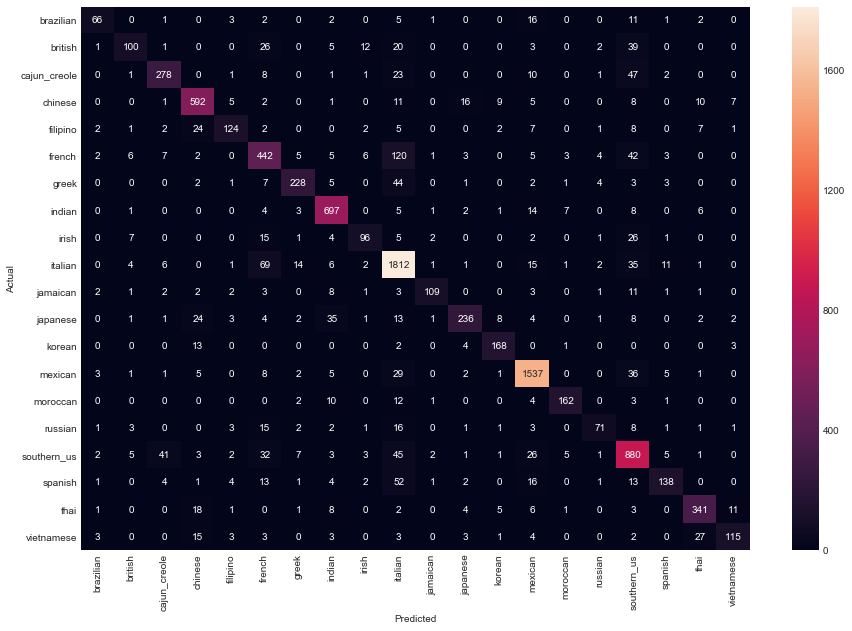

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=1)
y_pred = svm.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(cuisines),yticklabels=sorted(cuisines))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Since the dataset is imbalanced leaning towards italian, it is hard to pinpoint the accuracy of the model based on confusion matrix only. Therefore, a classification report is implemented where it dictates the precision, recall, f1-score for each cuisine.

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       110
           1       0.76      0.48      0.59       209
           2       0.81      0.75      0.77       373
           3       0.84      0.89      0.87       667
           4       0.81      0.66      0.73       188
           5       0.67      0.67      0.67       656
           6       0.85      0.76      0.80       301
           7       0.87      0.93      0.90       749
           8       0.76      0.60      0.67       160
           9       0.81      0.91      0.86      1981
          10       0.91      0.73      0.81       150
          11       0.86      0.68      0.76       346
          12       0.85      0.88      0.87       191
          13       0.91      0.94      0.93      1636
          14       0.90      0.83      0.86       195
          15       0.79      0.55      0.65       130
          16       0.74      0.83      0.78      1065
          17       0.80    

### Definition of Precision, Recall, F1-Score

#### Precision 
A higher value for precision means that the model was able to classify the cuisines correctly. 

#### Recall
A higher value of recall means that the model is able to catch most of the correctly classified cuisine.

#### F1-Score
This measure is just an average of precision and recall values.

## Interpretation of Results
The model is interpreted to create value based on how correlated each cuisine is with one another, whether the cuisine is distinct from one another or more similar to one another. 

The result of this can help chefs and restaurateurs to decide on a cuisine and optimizing the ingredients they use. With the identified distinct cuisines, it is recommended to just focus on one cuisine to save on ingredients. But with similar ones, this can be an opportunity for fusion restaurants by merging misclassified ones. Like how British and Irish cuisines are treated similarly based on their ingredients and often misclassified with each other. The results are valid since these are neighboring countries.

### More distinct cuisines
#### High Precision
Cuisines|Precision|Recall|F1-Score
--|--|--|--
Mexican|0.91|0.93|0.92
Jamaican|0.90|0.73|0.81
Moroccan|0.88|0.81|0.84

#### High Recall
Cuisines|Precision|Recall|F1-Score
--|--|--|--
Mexican|0.91|0.93|0.92
Indian|0.86|0.92|0.89
Italian|0.81|0.91|0.86

#### High F1-Score
Cuisines|Precision|Recall|F1-Score
--|--|--|--
Mexican|0.91|0.93|0.92
Indian|0.86|0.92|0.89
Korean|0.87|0.87|0.87

### More similar cuisines
#### Low Precision
Cuisines|Precision|Recall|F1-Score
--|--|--|--
Irish|0.69|0.53|0.60
Southern US|0.72|0.81|0.76
Brazilian|0.74|0.58|0.65

#### Low Recall
Cuisines|Precision|Recall|F1-Score
--|--|--|--
British|0.75|0.44|0.56
Russian|0.79|0.51|0.62
Irish|0.69|0.53|0.60

#### Low F1-Score
Cuisines|Precision|Recall|F1-Score
--|--|--|--
British|0.75|0.44|0.56
Irish|0.69|0.53|0.60
Russian|0.79|0.51|0.62

The results show that **Mexican, Jamaican and Indian Cuisines** are fairly distinct from the other cuisines while **British, Irish and Russian** are kind of similar with other cuisines. 

The key takeaway here is that confusion matrix can do much in getting insightful results like the one above and create value for chefs and restaurant owners by helping them optimize ingredients for specific cuisines.